#####  Machine Learning approach in steps

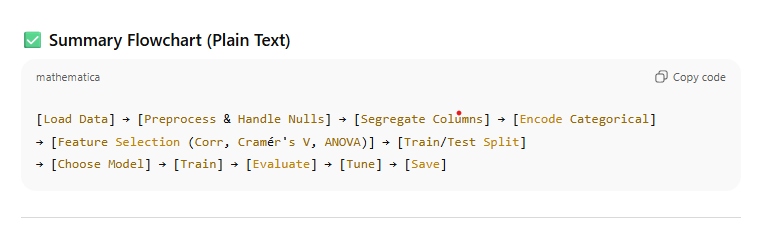
    

#### Machine Learning Steps

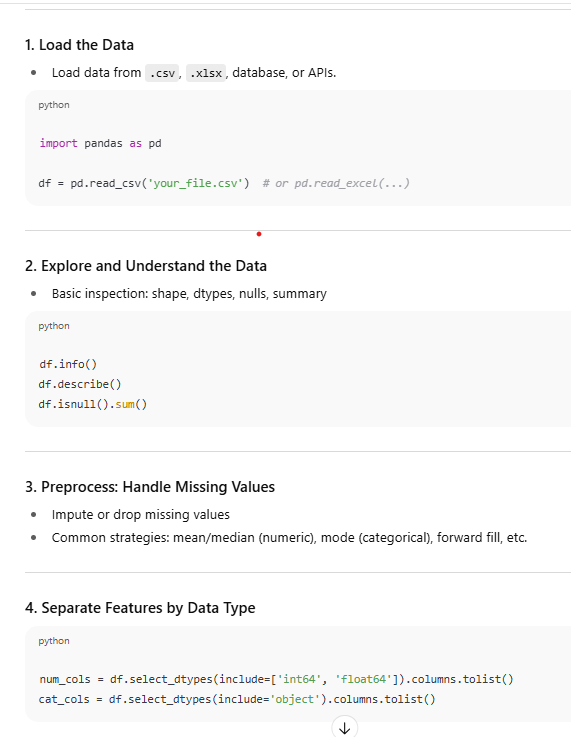
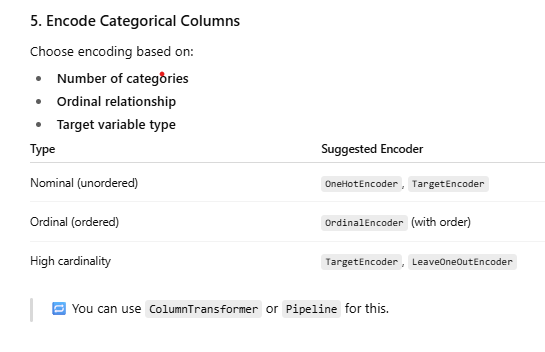
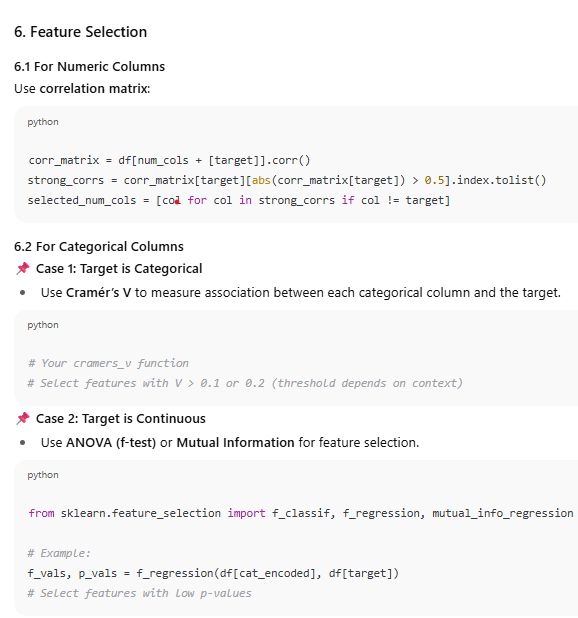
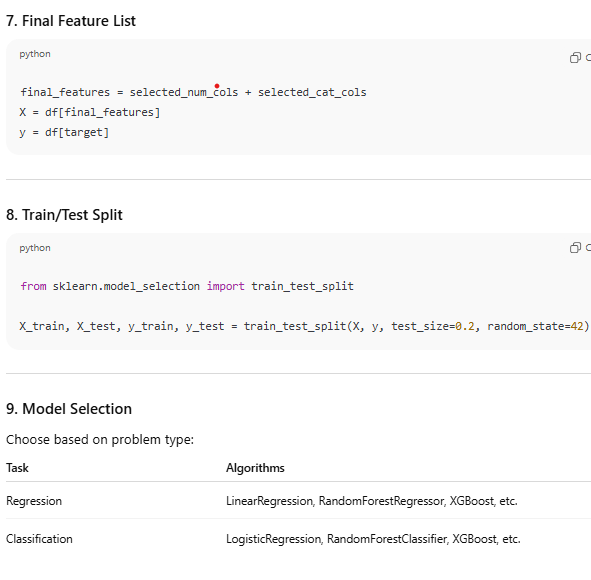
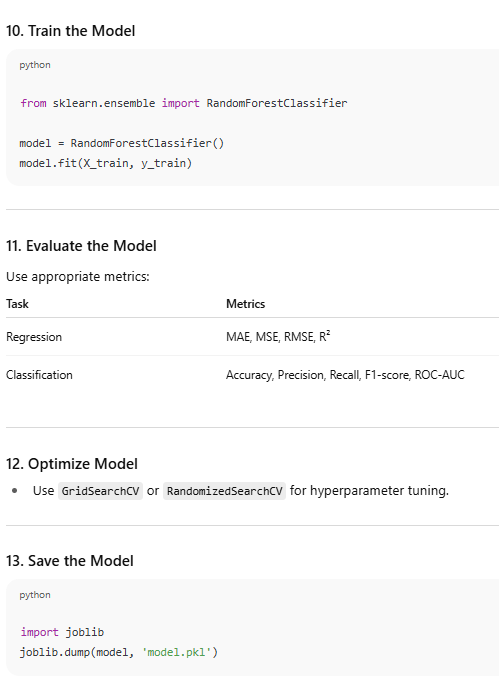

##### Matrix Table for Columns (Numeric, Categoric, Date/Time)
Matrix Table

| Feature Type    | Target Type     | Recommended Methods                                                                                           
| --------------- | --------------- | ----------------------------------------------------------- |
| **Numerical**   | **Numerical**   | 🔹 Pearson Correlation<br>🔹 Spearman Correlation (for non-linear/ordinal data)                              
| **Numerical**   | **Categorical** | 🔹 ANOVA (f\_classif)<br>🔹 Mutual Information<br>🔹 Point-Biserial (for binary target)                      
| **Categorical** | **Numerical**   | 🔹 ANOVA<br>🔹 Mutual Information (regression)<br>🔹 Decision Tree Feature Importance                        
| **Categorical** | **Categorical** | 🔹 Cramér’s V<br>🔹 Mutual Information (classification)<br>🔹 Chi-Square Test                                
| **Date/Time**   | **Any**         | 🔹 Extract features like: <br> • Day, Mnth, Hr, Day of Week, etc.<br>🔹 apply based on resulting feature type |

#### Cramers V Method

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency


def cramers_v(x, y, bias_correction=True):
    # Create cross tabulation of x, y
    contingency_table = pd.crosstab(x, y)
    # Get ChiSquare
    chi2, _, _, _ = chi2_contingency(contingency_table, correction=False)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2_final = 0.0
    r_final = 0.0
    k_final = 0.0
    if bias_correction:
        phi2_final = max(0, phi2 - ((r - 1) * (k - 1) / (n - 1)))
        r_final = r - ((r - 1) ** 2 / (n - 1))
        k_final = k - ((k - 1) ** 2 / (n - 1))
    else:
        phi2_final = phi2
        r_final = r
        k_final = k
    return np.sqrt(phi2_final / min(k_final - 1, r_final - 1))


x = ["A"] * 50 + ["B"] * 50
y = ["Yes"] * 30 + ["No"] * 20 + ["Yes"] * 10 + ["No"] * 40
assoc_strength = cramers_v(x, y, bias_correction=False)
print(f"Unbiased association strength: {assoc_strength}")
assoc_strength = cramers_v(x, y, bias_correction=True)
print(f"Biased association strength: {assoc_strength}")
# O/P: Unbiased association strength: 0.408248290463863 , Biased association strength: 0.3976974544878587

Unbiased association strength: 0.408248290463863
Biased association strength: 0.3976974544878587


#### Target Encoding Method

In [2]:
from sklearn.model_selection import KFold

# Sample data
df = pd.DataFrame(
    {
        "City": ["A", "B", "A", "C", "B", "C", "A", "B", "C", "A"],
        "Store_Type": ["X", "Y", "X", "Z", "Y", "X", "Y", "X", "Y", "Z"],
        "Sales": [100, 200, 110, 150, 190, 160, 105, 210, 170, 95],
    }
)

cat_cols = df.select_dtypes(include="object").columns
target_col = "Sales"


def kfold_target_encoded(df, target_col, cat_cols, n_splits=5, random_state=42):
    encoded_df = df.copy()
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

    for col in cat_cols:
        print(f"Target Encoding column: {col}")
        encoded_col = f"{col}_[target_encoded]"
        encoded_df[encoded_col] = np.nan
        for train_index, validation_index in kf.split(df):
            train = df.iloc[train_index]
            validation = df.iloc[validation_index]
            means = train.groupby(col)[target_col].mean()
            encoding_values = validation[col].map(means)
            encoded_df.iloc[
                validation_index, encoded_df.columns.get_loc(encoded_col)
            ] = encoding_values

        global_mean = df[target_col].mean()
        encoded_df[encoded_col] = encoded_df[encoded_col].fillna(global_mean)

    return encoded_df


encoded_df = kfold_target_encoded(df, target_col, cat_cols, n_splits=5, random_state=42)
encoded_df.head(3)

Target Encoding column: City
Target Encoding column: Store_Type


,City,Store_Type,Sales,City_[target_encoded],Store_Type_[target_encoded]
0,A,X,100,103.333333,160.0
1,B,Y,200,200.000000,147.5
2,A,X,110,100.000000,130.0


#### Ordinal & OneHot Encoding

In [3]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

import numpy as np

df = pd.DataFrame(
    {
        "A": [0, 1, 2, 3, 4],
        "B": ["Very Small", "Small", "Medium", "High", "Very High"],
        "C": ["Worst", "Bad", "Good", "Better", "Best"],
        "Markings": ["a", "b", "c", "d", "e"],
        "Comments": [
            "Need Improvement",
            "Need Improvement",
            "Slightly Better",
            "Good",
            "Good",
        ],
    }
)
ohe_cols = ["Markings", "Comments"]
ohe = OneHotEncoder(sparse_output=False, drop="first")
ohe_tuple = ("ohe", ohe, ohe_cols)

ord_cols = ["B", "C"]
size = ["Very Small", "Small", "Medium", "High", "Very High"]
ratings = ["Worst", "Bad", "Good", "Better", "Best"]
ord_encoder = OrdinalEncoder(categories=[size, ratings])
ord_encoder_tuple = ("ord", ord_encoder, ord_cols)

column_transformer = ColumnTransformer(
    transformers=[ohe_tuple, ord_encoder_tuple], remainder="passthrough"
)

encoded_array = column_transformer.fit_transform(df)
encoded_df = pd.DataFrame(
    encoded_array, columns=column_transformer.get_feature_names_out()
)
encoded_df

,ohe__Markings_b,ohe__Markings_c,ohe__Markings_d,ohe__Markings_e,ohe__Comments_Need Improvement,ohe__Comments_Slightly Better,ord__B,ord__C,remainder__A
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
2,0.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0
3,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,3.0
4,0.0,0.0,0.0,1.0,0.0,0.0,4.0,4.0,4.0


#### ANOVA - Analysis of Variance 

##### f_oneway

In [4]:
import pandas as pd
from scipy.stats import f_oneway

# Sample dataset with categorical features and numeric target
data = {
    "gender": ["M", "F", "F", "M", "F", "M", "M", "F"],
    "education": ["High", "High", "Low", "Low", "Medium", "Medium", "High", "Low"],
    "region": ["North", "South", "East", "West", "North", "East", "South", "West"],
    "score": [80, 75, 60, 90, 70, 85, 88, 65],  # target variable
}

df = pd.DataFrame(data)

# Separate features and target
target = "score"

# categorical columns
categorical_features = df.select_dtypes(include="object").columns

# Store significant features
significant_features = []

less_significant_features = []

# Iterate Categorical Columns
for col in categorical_features:
    print(f"\nColumn: [{col}]")
    # Adding all groups data per group
    groups = []
    for uniq_value in df[col].unique():
        group = df[df[col] == uniq_value][target]
        print(f"unique value = [{uniq_value}], unique value data = {group.tolist()}")
        groups.append(group)
        if len(groups) < 2:
            print(f"Skipping column: {col} due to single unique value in data")

    f_stat, p_val = f_oneway(*groups)
    print(f"\nf_stat: {f_stat:.2f}, p_val: {p_val:.4f}")

    if p_val <= 0.05:
        significant_features.append(col)
    else:
        less_significant_features.append(col)

print(f"\nSummary of Cat Features: Significant/ Less Significant")
print(f" - Significant Features: {significant_features}")
print(f" - Less Significant Features: {less_significant_features}")


Column: [gender]
unique value = [M], unique value data = [80, 90, 85, 88]
Skipping column: gender due to single unique value in data
unique value = [F], unique value data = [75, 60, 70, 65]

f_stat: 21.99, p_val: 0.0034

Column: [education]
unique value = [High], unique value data = [80, 75, 88]
Skipping column: education due to single unique value in data
unique value = [Low], unique value data = [60, 90, 65]
unique value = [Medium], unique value data = [70, 85]

f_stat: 0.46, p_val: 0.6534

Column: [region]
unique value = [North], unique value data = [80, 70]
Skipping column: region due to single unique value in data
unique value = [South], unique value data = [75, 88]
unique value = [East], unique value data = [60, 85]
unique value = [West], unique value data = [90, 65]

f_stat: 0.16, p_val: 0.9211

Summary of Cat Features: Significant/ Less Significant
 - Significant Features: ['gender']
 - Less Significant Features: ['education', 'region']


##### f_classif (Feature Selection)

In [5]:
from sklearn.feature_selection import f_classif
import numpy as np

# Sample dataset [Features: 4 samples, 3 features]
X = np.array([[700, 210, 102], [40, 22, 191], [1, 21, 0], [9678, 19, 16]])
# Binary target
y = np.array([0, 0, 1, 1])

f_values, p_values = f_classif(X, y)


for i, (f_stat, p_value) in enumerate(zip(f_values, p_values)):
    print(f"Feature: {i} , f_stat: {f_stat:.3f}, p_value: {p_value:.3f}")

Feature: 0 , f_stat: 0.849, p_value: 0.454
Feature: 1 , f_stat: 1.043, p_value: 0.415
Feature: 2 , f_stat: 9.384, p_value: 0.092


In [6]:
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

df = pd.DataFrame(
    {
        "City": ["A", "B", "A", "C", "B"],
        "Store_Type": ["X", "Y", "X", "Z", "Y"],
        "Sales": [100, 200, 110, 150, 190],
    }
)

# Sample data
df = pd.DataFrame(
    {
        "City": ["A", "B", "A", "C", "B", "C", "A", "B", "C", "A"],
        "Store_Type": ["X", "Y", "X", "Z", "Y", "X", "Y", "X", "Y", "Z"],
        "Sales": [100, 200, 110, 150, 190, 160, 105, 210, 170, 95],
    }
)


def kfold_target_encoded(
    df, target_col, target_encoding_cols, n_splits=5, random_state=42
):
    encoded_df = df.copy()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for col in target_encoding_cols:
        target_encoded_col = f"{col}_target_encoded"
        encoded_df[target_encoded_col] = np.nan
        print(f"Column: [{col}], Target Encoding Column: [{target_encoded_col}]\n")

        for train_index, validation_index in kf.split(df):
            # Train & Validation data
            train, validation = df.iloc[train_index], df.iloc[validation_index]

            # Means
            means = train.groupby(col)[target_col].mean()
            encoding_values = validation[col].map(means)
            print(f"Encoding Values: {encoding_values.to_numpy()}")

            encoded_df.iloc[
                validation_index, encoded_df.columns.get_loc(target_encoded_col)
            ] = encoding_values

        global_mean = df[target_col].mean()
        encoded_df[target_encoded_col] = encoded_df[target_encoded_col].fillna(
            global_mean
        )
    return encoded_df


target_encoding_cols = df.select_dtypes(include="object").columns
target_col = "Sales"

encoded_df = kfold_target_encoded(df, target_col, target_encoding_cols, 5, 42)
encoded_df.head(2)

Column: [City], Target Encoding Column: [City_target_encoded]

Encoding Values: [200. 155.]
Encoding Values: [103.33333333 160.        ]
Encoding Values: [100. 195.]
Encoding Values: [205. 105.]
Encoding Values: [165.         101.66666667]
Column: [Store_Type], Target Encoding Column: [Store_Type_target_encoded]

Encoding Values: [147.5 147.5]
Encoding Values: [160. 160.]
Encoding Values: [130. 130.]
Encoding Values: [158.33333333 150.        ]
Encoding Values: [ 95.         186.66666667]


,City,Store_Type,Sales,City_target_encoded,Store_Type_target_encoded
0,A,X,100,103.333333,160.0
1,B,Y,200,200.000000,147.5


#### Mutual Information
    Two types
         mutual_info_classif for classification tasks
         mutual_info_regression for regression tasks
    Note: Specify which features are discrete (categorical) using discrete_features

#### mutual_info_classif

In [7]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import numpy as np

# Sample data
X = pd.DataFrame(
    {
        "age": [22, 25, 47, 52, 46, 56, 55, 60],
        "income": [1500, 1800, 2500, 2600, 2700, 3000, 3200, 4000],
        "student": [1, 1, 0, 0, 0, 0, 0, 0],
    }
)

# Target: buys insurance (0 = No, 1 = Yes)
y = np.array([0, 0, 1, 1, 1, 1, 1, 1])

mi = mutual_info_classif(X, y, discrete_features=[False, False, True])

for feature, mi_score in zip(X.columns, mi):
    print(f"Feature: {feature}, mi_score: {mi_score}")

Feature: age, mi_score: 0.4636904761904761
Feature: income, mi_score: 0.2553571428571427
Feature: student, mi_score: 0.5623351446188082


#### mutual_info_regression

In [8]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import numpy as np

# Sample data
X = pd.DataFrame(
    {
        "age": [22, 25, 47, 52, 46, 56, 55, 60],
        "income": [1500, 1800, 2500, 2600, 2700, 3000, 3200, 4000],
        "student": [1, 1, 0, 0, 0, 0, 0, 0],
    }
)

# Target: Monthly Spending
y = np.array([0.1, 0.12, 0.3, 0.32, 0.4, 0.37, 0.39, 0.5])

mi = mutual_info_regression(X, y, discrete_features=[False, False, True])

for feature, mi_score in zip(X.columns, mi):
    print(f"Feature: {feature}, mi_score: {mi_score}")

X_shuffled = X.copy()
X_shuffled["student"] = np.random.permutation(X_shuffled["student"])

mi_shuffled = mutual_info_regression(
    X_shuffled, y, discrete_features=[False, False, True]
)
print(f"MI after shuffling student: {mi_shuffled}")

Feature: age, mi_score: 0.2657738095238096
Feature: income, mi_score: 0.4532738095238096
Feature: student, mi_score: 0.2553571428571427
MI after shuffling student: [0.26577381 0.45327381 0.        ]


#### Automate Correlation/Association Methods

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr, chi2_contingency, f_oneway
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression


# === 🔍 Helper functions ===
def is_numeric(col):
    return pd.api.types.is_numeric_dtype(col)


def is_categorical(col):
    return pd.api.types.is_object_dtype(col) or pd.api.types.is_categorical_dtype(col)


def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k, r) - 1))) if min(k, r) > 1 else 0.0


# === 🚀 Auto-detect and compute associations ===
def compute_associations(df, target):
    associations = []

    # Iterate for each column in Dataframe
    for col in df.columns:
        # Skip Target Column
        if col == target:
            continue

        # Get complete data of column to be compared with target column
        col_data = df[col]
        target_data = df[target]

        # Num-Num → Pearson/Spearman
        if is_numeric(col_data) and is_numeric(target_data):
            try:
                corr, _ = pearsonr(col_data, target_data)
                method = "pearson"
            except:
                corr, _ = spearmanr(col_data, target_data)
                method = "spearman"

        # Num-Cat → ANOVA or Mutual Info (classification)
        elif is_numeric(col_data) and is_categorical(target_data):
            try:
                groups = [col_data[target_data == cat] for cat in target_data.unique()]
                corr, _ = f_oneway(*groups)
                method = "anova"
            except:
                corr = mutual_info_classif(
                    col_data.values.reshape(-1, 1), target_data, discrete_features=False
                )[0]
                method = "mutual_info_classif"

        # Cat-Num → Mutual Info (regression)
        elif is_categorical(col_data) and is_numeric(target_data):
            try:
                corr = mutual_info_regression(pd.get_dummies(col_data), target_data)[0]
                method = "mutual_info_regression"
            except:
                corr = 0.0
                method = "error"

        # Cat-Cat → Chi² or Cramér's V
        elif is_categorical(col_data) and is_categorical(target_data):
            try:
                corr = cramers_v(col_data, target_data)
                method = "cramers_v"
            except:
                corr = 0.0
                method = "error"

        else:
            corr = None
            method = "unsupported"

        associations.append(
            {
                "Feature": col,
                "Method": method,
                "Association": round(corr, 4) if corr is not None else "N/A",
            }
        )

    return pd.DataFrame(associations)


# === 🔹 Sample mixed-type data ===
df = pd.DataFrame(
    {
        "age": [22, 25, 47, 52, 46, 56, 55, 60],
        "income": [1500, 1800, 2500, 2600, 2700, 3000, 3200, 4000],
        "student": ["yes", "yes", "no", "no", "no", "no", "no", "no"],
        "buys": [0, 0, 1, 1, 1, 1, 1, 1],  # Binary target
    }
)

# === ✅ Run the function ===
assoc_df = compute_associations(df, target="buys")
print(assoc_df)

   Feature                  Method  Association
0      age                 pearson       0.9453
1   income                 pearson       0.7956
2  student  mutual_info_regression       0.1625


#### Approach for automation of Correlation/Association Method

#### Steps

Load Data
Identify target
Create methods for identifying numeric, categoric
Possible combinations available
Iterate through df columns 
    1. Feature Column : Number , Target Column: Number
        Pearson (from scipy.stats import pearsonr)
        non/linear or Ordinal choose Spearman (from scipy.stats import spearmanr)
    2. Feature Column: Number , Target Column: Categoric
        ANOVA - Analysis of Variance from scipy.stats import f_oneway
        Mutual Information (Classification) (from sklearn.feature_selection import mutual_info_classif)
    3. Feature Column: Categoric, Target Column: Number
        Mutual Information Regression (from scipy.stats import mutual_info_regression)
    4. Feature Column: Categoric, Target Column: Categoric
        Cramers V (from scipy.stats import chi2_contingency)

In [10]:
from scipy.stats import f_oneway, chi2_contingency, pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.preprocessing import (
    OneHotEncoder,
    LabelEncoder,
    TargetEncoder,
    OrdinalEncoder,
)

# Numeric
from scipy.stats import pearsonr
from scipy.stats import spearmanr

# Categoric
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency

#### Linear Regression

In [11]:
import pandas as pd
import numpy as np
import re
import sys
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# -----------------------
# Sample dataset
# -----------------------
df = pd.DataFrame(
    {
        "age": [25, 32, 47, 51, 62],
        "gender": ["Male", "Female", "Female", "Male", "Female"],
        "signup_date": pd.to_datetime(
            ["2020-01-01", "2019-05-12", "2018-07-23", "2021-02-15", "2017-11-30"]
        ),
        "income": [50000, 60000, 80000, 72000, 90000],
    }
)

data = df.copy()

# -----------------------
# Classify columns using regex
# -----------------------


def classify_columns_by_type(df):
    numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    date_cols = df.select_dtypes(
        include=["datetime64[ns]", "datetime64"]
    ).columns.tolist()
    return numeric_cols, categorical_cols, date_cols


# -----------------------
# Feature Engineering
# -----------------------

# Convert date column to numerical feature (e.g., days since signup)
data["days_since_signup"] = (pd.Timestamp.now() - data["signup_date"]).dt.days

numeric_cols, categorical_cols, date_cols = classify_columns_by_type(
    data.drop(columns="income")
)

# Final feature list
features = numeric_cols + categorical_cols
target = "income"

# Column Transformers List
encoder_type = "ohe_123"
ohe_encoder = OneHotEncoder(drop="first")
ohe_cols = categorical_cols

# Column Transformer Tuples
ohe_tuple = (encoder_type, ohe_encoder, ohe_cols)

# --------------------------------
# Preprocessing & Modeling Pipeline
# ---------------------------------

X = data[features]
y = data[target]

preprocessor = ColumnTransformer(transformers=[ohe_tuple], remainder="passthrough")

# Pipeline Step Tuples
preprocessor_tuple = ("preprocessor", preprocessor)
regressor_tuple = ("regressor", LinearRegression())

model = Pipeline(steps=[preprocessor_tuple, regressor_tuple])

print(
    f"Extra Column(s) added for performing regression: {set(data.columns.tolist()) - set(df.columns.tolist())}"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.2f}")

Extra Column(s) added for performing regression: {'days_since_signup'}
Root Mean Squared Error: 10330.75


#### Linear Regression - Version 2

In [12]:
import pandas as pd
import numpy as np
import re
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


class DynamicLinearRegressionPipeline:
    def __init__(self, df, target_col="target", remove_duplicates=True):
        self.df = df.copy()
        self.target_col = target_col
        self.remove_duplicates = remove_duplicates

        # Configs
        self.ohe_regex = re.compile(r"gender", re.IGNORECASE)
        self.ord_regex = re.compile(r"education_level", re.IGNORECASE)
        self.ordinal_mappings = {
            "education_level": ["High School", "Bachelor", "Master", "PhD"]
        }

        # Will be populated later
        self.numeric_cols = []
        self.categorical_cols = []
        self.date_cols = []
        self.ohe_cols = []
        self.ord_cols = []

    # ---------------
    # Update OneHotEncoding Reg Expression
    # ---------------
    def set_ohe_regex(self, pattern):
        self.ohe_regex = re.compile(pattern, re.IGNORECASE)

    def set_ord_regex(self, pattern):
        self.ord_regex = re.compile(pattern, re.IGNORECASE)

    # ---------------------------------
    # Column Classification
    # ---------------------------------
    def classify_columns(self):
        self.numeric_cols = self.df.select_dtypes(include=["number"]).columns.tolist()
        self.categorical_cols = self.df.select_dtypes(
            include=["object", "category"]
        ).columns.tolist()
        self.date_cols = self.df.select_dtypes(
            include=["datetime64[ns]", "datetime64"]
        ).columns.tolist()

    # ---------------------------------
    # Feature Engineering
    # ---------------------------------
    def extract_new_features(self):
        for col in self.date_cols:
            new_col = f"days_since_{col}"
            self.df[new_col] = (pd.Timestamp.now() - self.df[col]).dt.days
            self.numeric_cols.append(new_col)

    # ---------------------------------
    # Handle Missing Values
    # ---------------------------------
    def handle_missing_values(self):
        for col in self.numeric_cols:
            if self.df[col].isna().any():
                skew = self.df[col].skew()
                fill_val = (
                    self.df[col].median() if abs(skew) > 0.5 else self.df[col].mean()
                )
                self.df[col] = self.df[col].fillna(fill_val)

        for col in self.categorical_cols:
            if self.df[col].isna().any():
                self.df[col] = self.df[col].fillna(self.df[col].mode()[0])

    # ---------------------------------
    # Populate Data after Cleaning
    # ---------------------------------
    def populate_data(self):
        if self.remove_duplicates:
            self.df = self.df.drop_duplicates()

        self.classify_columns()
        self.extract_new_features()
        self.handle_missing_values()

        if self.target_col in self.numeric_cols:
            self.numeric_cols.remove(self.target_col)

    # ---------------------------------
    # Encoding Column Selection
    # ---------------------------------
    def select_encoding_columns(self):
        self.ohe_cols = [
            col for col in self.categorical_cols if self.ohe_regex.search(col)
        ]
        self.ord_cols = [
            col
            for col in self.categorical_cols
            if self.ord_regex.search(col) and col not in self.ohe_cols
        ]

    # ---------------------------------
    # Populate Pipeline
    # ---------------------------------
    def populate_pipeline(self):
        self.select_encoding_columns()
        transformers = []

        if self.ohe_cols:
            transformers.append(
                ("ohe", OneHotEncoder(drop="first", sparse_output=False), self.ohe_cols)
            )

        if self.ord_cols:
            ord_categories = [
                self.ordinal_mappings.get(col, None) for col in self.ord_cols
            ]
            transformers.append(
                ("ord", OrdinalEncoder(categories=ord_categories), self.ord_cols)
            )

        # preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')
        preprocessor = ColumnTransformer(transformers=transformers)

        pipeline = Pipeline(
            steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
        )

        return pipeline

    # ---------------------------------
    # Populate Features
    # ---------------------------------
    def populate_features(self):
        all_cols = list(
            dict.fromkeys(self.numeric_cols + self.ohe_cols + self.ord_cols)
        )
        X = self.df[all_cols]
        y = self.df[self.target_col]
        return X, y

    # ---------------------------------
    # Training and Evaluation
    # ---------------------------------
    def train_and_evaluate(self):
        # Populate Data ( Drop Duplicates, Classify Cols, Extract New Features, Handle Null Values)
        self.populate_data()
        # Populate Pipeline ( Classify Encoding Type Columns, Add to Transformer list, create pipeline)
        pipeline = self.populate_pipeline()
        # Populate Features ( X =Create a set (unique) from numerical, ordinal, onehot encoded columns, y = target)
        X, y = self.populate_features()

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"Training Features: {X.columns}, RMSE: {rmse:.2f}")
        return f"✅ RMSE: {rmse:.2f}"

    # ---------------------------------
    # Run Everything
    # ---------------------------------
    def run(self):
        return self.train_and_evaluate()


if __name__ == "__main__":
    # -----------------------
    # Sample dataset
    # -----------------------
    df = pd.DataFrame(
        {
            "age": [25, 32, 47, 51, 62, 47, np.nan],
            "income": [50000, 60000, 80000, 72000, 90000, 80000, 85000],
            "gender": ["Male", "Female", "Female", "Male", np.nan, "Female", "Female"],
            "education_level": [
                "Bachelor",
                "Master",
                "PhD",
                "Master",
                "Bachelor",
                "PhD",
                "Master",
            ],
            "signup_date": pd.to_datetime(
                [
                    "2020-01-01",
                    "2019-05-12",
                    "2018-07-23",
                    "2021-02-15",
                    "2017-11-30",
                    "2018-07-23",
                    "2019-05-12",
                ]
            ),
            "target": [200, 250, 340, 300, 400, 340, 260],
        }
    )

    lin_regression = DynamicLinearRegressionPipeline(df, "income", True)
    lin_regression.set_ohe_regex(r"gender")
    lin_regression.set_ord_regex(r"education_level")
    lin_regression.run()

Training Features: Index(['age', 'target', 'days_since_signup_date', 'gender', 'education_level'], dtype='object'), RMSE: 26019.22


#### LogisticRegression (Classification)

In [13]:
import pandas as pd
import numpy as np
import re
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


class DynamicClassificationPipeline:
    def __init__(self, df, target_col="target", remove_duplicates=True):
        self.df = df.copy()
        self.target_col = target_col
        self.remove_duplicates = remove_duplicates

        # Configs (Regex-based encoding detection)
        self.ohe_regex = re.compile(r"gender", re.IGNORECASE)
        self.ord_regex = re.compile(r"education_level", re.IGNORECASE)
        self.ordinal_mappings = {
            "education_level": ["High School", "Bachelor", "Master", "PhD"]
        }

        # Column placeholders
        self.numeric_cols = []
        self.categorical_cols = []
        self.date_cols = []
        self.ohe_cols = []
        self.ord_cols = []

    # ----------------------------
    # Update OneHotEncoding Reg Ex
    # ----------------------------
    def set_ohe_regex(self, pattern):
        self.ohe_regex = re.compile(pattern, re.IGNORECASE)

    # ------------------------------
    # Update Ordinal Encoding Reg Ex
    # ------------------------------
    def set_ord_regex(self, pattern):
        self.ord_regex = re.compile(pattern, re.IGNORECASE)

    # ---------------------------------
    def classify_columns(self):
        self.numeric_cols = self.df.select_dtypes(include=["number"]).columns.tolist()
        self.categorical_cols = self.df.select_dtypes(
            include=["object", "category"]
        ).columns.tolist()
        self.date_cols = self.df.select_dtypes(
            include=["datetime64[ns]", "datetime64"]
        ).columns.tolist()

    # ---------------------------------
    def extract_new_features(self):
        for col in self.date_cols:
            new_col = f"days_since_{col}"
            self.df[new_col] = (pd.Timestamp.now() - self.df[col]).dt.days
            self.numeric_cols.append(new_col)

    # ---------------------------------
    def handle_missing_values(self):
        for col in self.numeric_cols:
            if self.df[col].isna().any():
                skew = self.df[col].skew()
                fill_val = (
                    self.df[col].median() if abs(skew) > 0.5 else self.df[col].mean()
                )
                self.df[col] = self.df[col].fillna(fill_val)

        for col in self.categorical_cols:
            if self.df[col].isna().any():
                self.df[col] = self.df[col].fillna(self.df[col].mode()[0])

    # -----------------------------------------------------------------------------------------
    # Populate Data ( Drop Duplicates, Classify Cols, Extract New Features, Handle Null Values)
    # -----------------------------------------------------------------------------------------
    def populate_data(self):
        if self.remove_duplicates:
            self.df = self.df.drop_duplicates()

        self.classify_columns()
        self.extract_new_features()
        self.handle_missing_values()

        if self.target_col in self.numeric_cols:
            self.numeric_cols.remove(self.target_col)

    # ---------------------------------
    def populate_pipeline(self):
        self.ohe_cols = [
            col for col in self.categorical_cols if self.ohe_regex.search(col)
        ]
        self.ord_cols = [
            col
            for col in self.categorical_cols
            if self.ord_regex.search(col) and col not in self.ohe_cols
        ]

        transformers = []

        if self.ohe_cols:
            transformers.append(
                ("ohe", OneHotEncoder(drop="first", sparse_output=False), self.ohe_cols)
            )

        if self.ord_cols:
            ord_categories = [
                self.ordinal_mappings.get(col, None) for col in self.ord_cols
            ]
            transformers.append(
                ("ord", OrdinalEncoder(categories=ord_categories), self.ord_cols)
            )

        preprocessor = ColumnTransformer(
            transformers=transformers, remainder="passthrough"
        )

        pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("classifier", LogisticRegression(max_iter=200)),
            ]
        )

        return pipeline

    # ---------------------------------
    def populate_features(self):
        all_cols = list(
            dict.fromkeys(self.numeric_cols + self.ohe_cols + self.ord_cols)
        )
        X = self.df[all_cols]
        y = self.df[self.target_col]
        return X, y

    # ---------------------------------
    def train_and_evaluate(self):
        # Populate Data ( Drop Duplicates, Classify Cols, Extract New Features, Handle Null Values)
        self.populate_data()
        # Populate Pipeline ( Classify Encoding Type Columns, Add to Transformer list, create pipeline)
        pipeline = self.populate_pipeline()
        # Populate Features ( X =Create a set (unique) from numerical, ordinal, onehot encoded columns, y = target)
        X, y = self.populate_features()

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        return f"✅ Accuracy: {accuracy:.2%}"

    # ---------------------------------
    def run(self):
        return self.train_and_evaluate()


if __name__ == "__main__":
    df = pd.DataFrame(
        {
            "age": [25, 32, 47, 51, 62, 47, np.nan],
            "gender": ["Male", "Female", "Female", "Male", np.nan, "Female", "Female"],
            "education_level": [
                "Bachelor",
                "Master",
                "PhD",
                "Master",
                "Bachelor",
                "PhD",
                "Master",
            ],
            "signup_date": pd.to_datetime(
                [
                    "2020-01-01",
                    "2019-05-12",
                    "2018-07-23",
                    "2021-02-15",
                    "2017-11-30",
                    "2018-07-23",
                    "2019-05-12",
                ]
            ),
            "target": [0, 1, 1, 0, 1, 1, 0],  # Binary classification target
        }
    )

    model = DynamicClassificationPipeline(df, target_col="target")
    result = model.run()
    print(result)

✅ Accuracy: 50.00%


#### Multiple Pipelines

In [15]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import skew
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ------------------------------
# Sample Data
# ------------------------------
df = pd.DataFrame(
    {
        "age": [25, 32, 47, 51, np.nan, 38],
        "income": [50000, 60000, np.nan, 72000, 90000, 58000],
        "gender": ["Male", "Female", "Female", "Male", "Female", "Female"],
        "education": ["Bachelor", "Master", "PhD", "PhD", np.nan, "Bachelor"],
        "target": [0, 1, 1, 0, 1, 0],
    }
)
target = "target"
# ------------------------------
# Column Groups
# ------------------------------
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
ordinal_cols = ["education"]
numeric_mean_cols = []
numeric_median_cols = []

categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
nominal_cols = list(set(categorical_cols) - set(ordinal_cols))
if target in numeric_cols:
    numeric_cols.remove(target)
if target in ordinal_cols:
    ordinal_cols.remove(target)
if target in nominal_cols:
    nominal_cols.remove(target)

education_order = [["High School", "Bachelor", "Master", "PhD"]]

for col in numeric_cols:
    col_skew = skew(df[col].dropna())
    print(f"Column: {col} and Skew : {col_skew}")
    if abs(col_skew) > 0.5:
        numeric_median_cols.append(col)
    else:
        numeric_mean_cols.append(col)

print(f"Total cols: {df.columns}")
print(f"numeric_median_cols: {numeric_median_cols}")
print(f"numeric_mean_cols: {numeric_mean_cols}")
print(f"nominal_cols: {nominal_cols}")
print(f"ordinal_cols: {ordinal_cols}")
print(f"target col: {target}")

# ------------------------------
# Numeric Pipeline
# ------------------------------
numeric_median_imputer_tuple = ("num_imputer", SimpleImputer(strategy="median"))
scaler_tuple = ("scaler", StandardScaler())

numeric_median_pipeline = Pipeline(steps=[numeric_median_imputer_tuple, scaler_tuple])

numeric_mean_imputer_tuple = ("num_imputer", SimpleImputer(strategy="mean"))
scaler_tuple = ("scaler", StandardScaler())

numeric_mean_pipeline = Pipeline(steps=[numeric_mean_imputer_tuple, scaler_tuple])

# ------------------------------
# OneHot Encoding Pipeline
# ------------------------------
nominal_imputer_tuple = ("nom_imputer", SimpleImputer(strategy="most_frequent"))
ohe_tuple = ("ohe", OneHotEncoder(drop="first", sparse_output=False))

nominal_pipeline = Pipeline(steps=[nominal_imputer_tuple, ohe_tuple])

# ------------------------------
# Ordinal Encoding Pipeline
# ------------------------------
ordinal_imputer_tuple = ("ord_imputer", SimpleImputer(strategy="most_frequent"))
ord_tuple = ("ord", OrdinalEncoder(categories=education_order))

ordinal_pipeline = Pipeline(steps=[ordinal_imputer_tuple, ord_tuple])

# ------------------------------
# Combine with ColumnTransformer
# ------------------------------
numeric_mean_pipeline_tuple = ("num_mean", numeric_mean_pipeline, numeric_mean_cols)
numeric_median_pipeline_tuple = (
    "num_median",
    numeric_median_pipeline,
    numeric_median_cols,
)
nominal_pipeline_tuple = ("nom", nominal_pipeline, nominal_cols)
ordinal_pipeline_tuple = ("ord", ordinal_pipeline, ordinal_cols)
transformers = [
    numeric_mean_pipeline_tuple,
    numeric_median_pipeline_tuple,
    nominal_pipeline_tuple,
    ordinal_pipeline_tuple,
]

preprocessor = ColumnTransformer(transformers=transformers)

# ------------------------------
# Final Pipeline
# ------------------------------
preprocessor_tuple = ("preprocessor", preprocessor)
evaluation_tuple = ("classifier", LogisticRegression(max_iter=200))

model_pipeline = Pipeline(steps=[preprocessor_tuple, evaluation_tuple])

# ------------------------------
# Train/Test Split and Fit
# ------------------------------
X = df.drop(columns="target")
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model_pipeline.fit(X_train, y_train)
X_transformed = model_pipeline.named_steps["preprocessor"].transform(X)
print("\nNulls in transformed data (should be 0):")
print(np.isnan(X_transformed).sum())
y_pred = model_pipeline.predict(X_test)

# ------------------------------
# Evaluation
# ------------------------------
acc = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {acc:.2%}")
# ------------------------------
# Confusion Matrix
# ------------------------------
cm = confusion_matrix(y_test, y_pred)
print(cm)

Column: age and Skew : -0.07041985034396127
Column: income and Skew : 0.684249411065735
Total cols: Index(['age', 'income', 'gender', 'education', 'target'], dtype='object')
numeric_median_cols: ['income']
numeric_mean_cols: ['age']
nominal_cols: ['gender']
ordinal_cols: ['education']
target col: target

Nulls in transformed data (should be 0):
0
✅ Accuracy: 50.00%
[[1 0]
 [1 0]]


In [16]:
help(DynamicClassificationPipeline)

Help on class DynamicClassificationPipeline in module __main__:

class DynamicClassificationPipeline(builtins.object)
 |  DynamicClassificationPipeline(df, target_col='target', remove_duplicates=True)
 |
 |  Methods defined here:
 |
 |  __init__(self, df, target_col='target', remove_duplicates=True)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  classify_columns(self)
 |      # ---------------------------------
 |
 |  extract_new_features(self)
 |      # ---------------------------------
 |
 |  handle_missing_values(self)
 |      # ---------------------------------
 |
 |  populate_data(self)
 |      # -----------------------------------------------------------------------------------------
 |      # Populate Data ( Drop Duplicates, Classify Cols, Extract New Features, Handle Null Values)
 |      # -----------------------------------------------------------------------------------------
 |
 |  populate_features(self)
 |      # -----------------------------